In [2]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import sys, os
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.join(os.path.abspath(''),'..','scripts'))
sys.path.append(os.path.join(os.path.abspath(''),'..','src'))

from scipy.stats import entropy
from scipy.interpolate import CubicSpline
from numpy.linalg import norm
import numpy as np
from sklearn.metrics import r2_score

def get_all_fake_values(y, x, n):
    cs = CubicSpline(x, y, extrapolate=True)
    return np.array(cs(range(int(n))))

def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _P[_P <= 0] = 1
    _Q[_Q <= 0] = 1
    
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

def rel_diff(true_y, false_y):
    return r2_score(true_y, false_y)

def get_adversary_sequences(df):
    listdic = df
    d = {}
    for el in listdic:
        if el == None:
            continue
        for sname in el:
            if sname not in d:
                d[sname] = []
            d[sname].append(el[sname])
    return d

from Experiment import *
from Analyzer import *
from Artist import *
artist = Artist()

In [3]:
results = Analyzer("dblp").df
results = results.drop_duplicates(subset='cmd', keep="last")

Text(0, 0.5, '$\\mathcal{I}$')

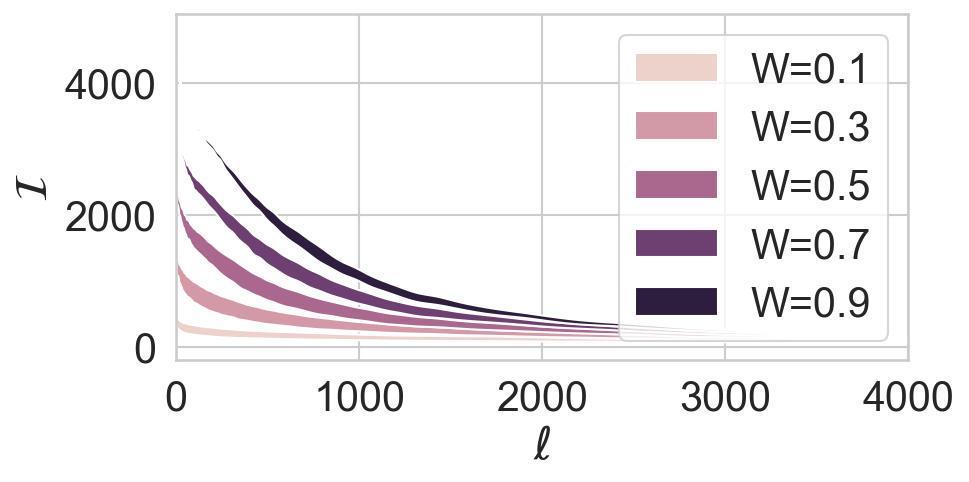

In [24]:
# sns.set(style="whitegrid", font_scale=1.4, rc={'axes.grid': True})
# fig = plt.figure(figsize=(4,3), dpi=120)
# ax = fig.add_subplot(1, 1, 1)

sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True})
sns.set_palette(sns.cubehelix_palette(5))
fig = plt.figure(figsize=(6.3, 3.05), dpi=150)
ax = fig.add_subplot(1, 1, 1)

sns.set_palette(sns.cubehelix_palette(5))

i = 0
vals = []
for w in sorted(results['weight_scale'].unique()):
    dd = results[results['weight_scale'] == w]
    
    emf = dd[dd['mode'] == 5]
    emf_seq = np.amin([emf.loc[i,'sequence'] for i in emf.index],axis=0)

    emf = dd[dd['mode'] == 0]
    emf_seq2 = np.amin([emf.loc[i,'sequence'] for i in emf.index],axis=0)
    
    seq1 = get_all_fake_values(emf_seq, dd.iloc[0]['samples_blocked_values'], dd.iloc[0]['n'])
    seq2 = get_all_fake_values(emf_seq2, dd.iloc[0]['samples_blocked_values'], dd.iloc[0]['n'])
    plt.fill_between(list(range(len(seq1))), seq1, seq2, label="W={}".format(w))
    vals.append(sum(seq1)-sum(seq2))

    i += 1
plt.legend()
plt.xlim((0,4000))
plt.xlabel("$\ell$")
plt.ylabel(r'$\mathcal{I}$')

Text(0, 0.5, 'Sum')

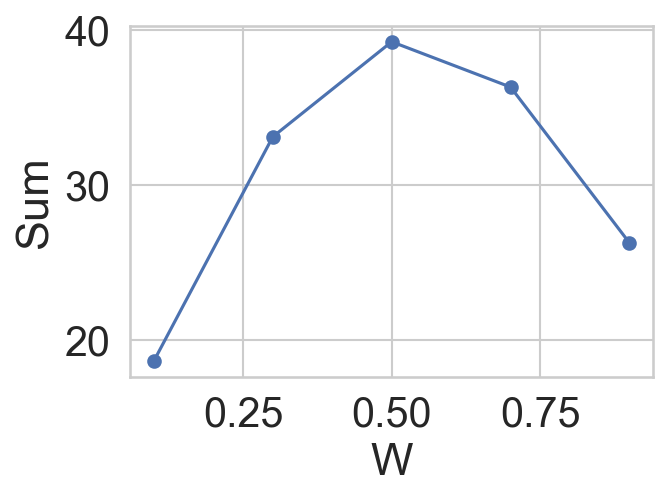

In [25]:
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True})
fig = plt.figure(figsize=(4.5, 3.1), dpi=150)
ax = fig.add_subplot(1, 1, 1)
plt.plot(sorted(results['weight_scale'].unique()),np.array(vals)/results.iloc[0]['n'],'-o')
plt.xlabel("W")
plt.ylabel("Sum")

In [26]:
result = Analyzer("dblp_alpha").df

In [27]:
result[result['alpha'] == 1][result['mode'] == 0]['Total imm time'].sum()

/Users/au624601/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


81.9923050403595

In [28]:
rr = []
for mode in [0,5]:
    df = result
    r = {}
    r2 = {}
    r3 = {}
    for s in sorted(df['solver'].unique()):
        if s == "single_greedy_celf":
            continue
        df = result
        df = df[df['mode'] == mode]
        df = df[df['solver'] == s]

        assert(len(df[df['alpha']==1]) == 1)
        true_values = df[df['alpha']==1].iloc[0]['sequence']
        for alpha in df['alpha'].unique():
            assert(len(df[df['alpha']==alpha]) == 1)
            fake_values = df[df['alpha']==alpha].iloc[0]['sequence']
            fake_x = df[df['alpha']==alpha].iloc[0]['samples_blocked_values']
            fake_all = get_all_fake_values(fake_values, fake_x, len(true_values))
            if alpha not in r:
                r[alpha] = 0
#                 r[alpha] = 1
                r3[alpha] = 0
            r[alpha] += rel_diff(true_values, fake_all)
#             r[alpha] = min(rel_diff(true_values, fake_all), r[alpha])
#             r[alpha] += JSD(true_values, fake_all)
            r2[alpha] = len(fake_x)
            r3[alpha] += df[df['alpha']==alpha].iloc[0]['runtime']/10**9
    #         print(alpha,rel_diff(true_values, fake_all))
    r = [(alpha, r[alpha]/(len(result['solver'].unique())-1)) for alpha in r]
#     r = [(alpha, r[alpha]) for alpha in r]

    r3 = [(alpha, r3[alpha]/(len(result['solver'].unique())-1)) for alpha in r3]
    r2 = [(alpha, r2[alpha]) for alpha in r2]
    r = pd.DataFrame(r)
    r = r.sort_values(0)
    r2 = pd.DataFrame(r2)
    r2 = r2.sort_values(0)
    r3 = pd.DataFrame(r3)
    r3 = r3.sort_values(0)
    rr.append((r,r2,r3))
    


r = {}
r2 = {}
r3 = {}

df = result
df = df[df['mode'].isna()]
# print(df['alpha'])
assert(len(df[df['alpha']==1.01]) == 1)
fake_values = get_adversary_sequences(df[df['alpha']==1.01].iloc[0]['objective_per_adversary'])
true_values = {}
for s in fake_values:
    true_values[s] = get_all_fake_values(fake_values[s], df[df['alpha']==1.01].iloc[0]['samples_blocked_values'], df.iloc[0]['n'])
for alpha in df['alpha'].unique():
    dd = df[df['alpha'] == alpha]
    assert(len(dd) == 1)
    d = get_adversary_sequences(dd.iloc[0]['objective_per_adversary'])
    fake_x = dd.iloc[0]['samples_blocked_values']
    for s in d:
        fake_values = d[s]
        fake_all = get_all_fake_values(fake_values, fake_x[:len(fake_values)], len(true_values[s]))
        if alpha not in r:
            r[alpha] = 0
#             r[alpha] = 1
            r3[alpha] = 0
        r[alpha] += rel_diff(true_values[s], fake_all)
#         r[alpha] += JSD(true_values[s], fake_all)
#         r[alpha] = min(rel_diff(true_values[s], fake_all), r[alpha])
        r2[alpha] = len(fake_x)
    r3[alpha] = (df[df['alpha']==alpha].iloc[0]['time'] + df[df['alpha']==alpha].iloc[0]['dim_time'])/10**9


r = [(alpha, r[alpha]/(len(result['solver'].unique())-1)) for alpha in r]
# r = [(alpha, r[alpha]) for alpha in r]
r3 = [(alpha, r3[alpha]/(len(result['solver'].unique())-1)) for alpha in r3]
r2 = [(alpha, r2[alpha]) for alpha in r2]
r = pd.DataFrame(r)
r = r.sort_values(0)
r2 = pd.DataFrame(r2)
r2 = r2.sort_values(0)
r3 = pd.DataFrame(r3)
r3 = r3.sort_values(0)
rr.append((r,r2,r3))

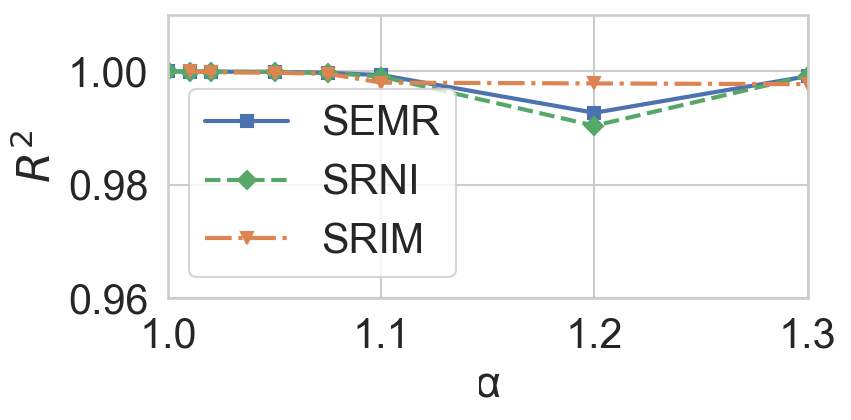

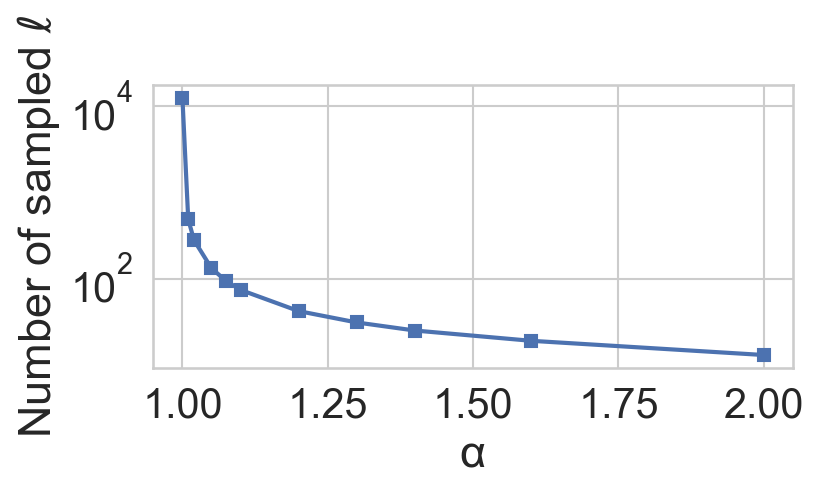

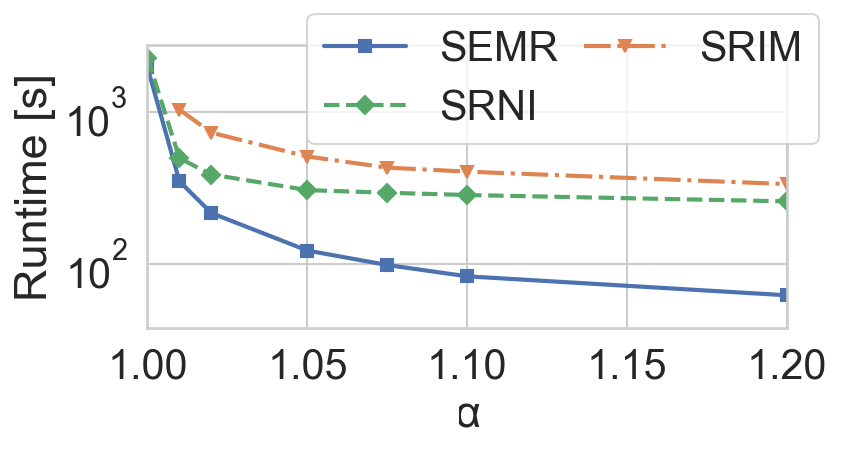

In [40]:
# sns.set(style="whitegrid", font_scale=1.4, rc={'axes.grid': True})
sns.set(style="whitegrid", font_scale=1.8, rc={'axes.grid': True})
current_palette = sns.color_palette()
lw = 2

# fig = plt.figure(figsize=(4,3), dpi=120)
fig = plt.figure(figsize=(5.5, 2.5), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(rr[1][0][0], rr[1][0][1], label="SEMR", marker=artist.markers[1], linestyle=artist.markers_and_lines[1][0],linewidth=lw)
ax.plot(rr[0][0][0], rr[0][0][1], label="SRNI", marker=artist.markers[0], linestyle=artist.markers_and_lines[0][0], color=current_palette[2],linewidth=lw)
ax.plot(rr[2][0][0], rr[2][0][1], label="SRIM", marker=artist.markers[2], linestyle=artist.markers_and_lines[2][0],linewidth=lw)
# ax.set_yscale("log")
ax.set_ylim((0.96,1.01))
ax.set_xlim((1,1.3))
ax.set_ylabel("$R^2$")
ax.set_xlabel("α")
ax.legend()
plt.show()

# fig = plt.figure(figsize=(4,3), dpi=120)
fig = plt.figure(figsize=(5.5, 2.5), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(rr[1][1][0], rr[1][1][1], label="SEMR", marker=artist.markers[1], linestyle=artist.markers_and_lines[1][0],linewidth=lw)
# ax.plot(rr[0][1][0], rr[0][1][1], label="SRNI", marker=artist.markers[0], linestyle=artist.markers_and_lines[0][0], color=current_palette[2])
# ax.plot(rr[2][1][0], rr[2][1][1], label="SRIM", marker=artist.markers[2], linestyle=artist.markers_and_lines[2][0])
ax.set_yscale("log")
ax.set_ylabel("Number of sampled $\ell$")
ax.set_xlabel("α")
# ax.legend()
plt.show()


# fig = plt.figure(figsize=(4,3), dpi=120)
fig = plt.figure(figsize=(5.5, 2.5), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(rr[1][2][0], rr[1][2][1], label="SEMR", marker=artist.markers[1], linestyle=artist.markers_and_lines[1][0],linewidth=lw)
ax.plot(rr[0][2][0], rr[0][2][1], label="SRNI", marker=artist.markers[0], linestyle=artist.markers_and_lines[0][0], color=current_palette[2],linewidth=lw)
ax.plot(rr[2][2][0], rr[2][2][1], label="SRIM", marker=artist.markers[2], linestyle=artist.markers_and_lines[2][0],linewidth=lw)
ax.set_yscale("log")
ax.set_xlabel("α")
ax.set_ylabel("Runtime [s]")
ax.set_xlim((1,1.2))
ax.legend(bbox_to_anchor=(0.25, 0.65, 0.8, 0), loc=0, ncol=2, mode="expand", borderaxespad=0.)
plt.show()